## Image Processing - scc0251
# Mosaic

Authors: Eleazar Fernando Braga (10295537), Lucas Faria Hermeto (10295687)

Video: https://drive.google.com/file/d/100rvXNvR98y0Tklk8_gIwb3JaA10Ndgz/view

OBS: The hole project was develop by pair programming, that's why we don't have much division of commits

## Abstract 
The main goal of this project's to apply transformation on images and convert them to pixel art and transform pixel art to tiny images

So first, we will start importing some libraries

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

Now, the first thing we should do it's load the image and start with some params like output image size. 

OBS: Remembering that our image must have an uniform background and de output size must be: 32, 64 or 128 pixels.

(-0.5, 127.5, 183.5, -0.5)

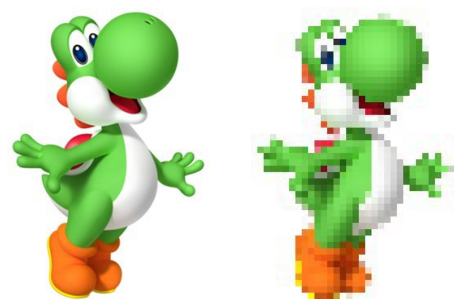

In [2]:
image = imageio.imread('README/example1.jpg')
output_intended = imageio.imread('README/example1.out.jpg')

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(image, vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(output_intended, vmin=0, vmax=255)
plt.axis('off')

We load an image called `output_intended` that will be our goal with the original image applying some redimension methods and fix the image later.

### PCA
So, to resize our image we're going to apply an method called Principal Components Analytics that it's used to redimension a dataset, for example, we have a dataset with 30 attributes and we will use PCA to get only 4 principals. The advantage of PCA it's that we will not lose the image params becase we will use the covariance matrix for filtering.

So our `pca` method will receive the image as an input and `k` that indicates the size which we will redimension our matrix.

As we're trying to use a RGB image, we need to convert the matrix to 2 dimensions.

Now we go to the next step of PCA, calculate the covariance matrix that will maintain the relation between the columns.

And we're going to resize the image by column.

Having the covariance matrix, we can calculate the eigenvalues and eigenvectors and finaly use them to get our new image resized mutiplying the image with the eigenvalues selected.

(-0.5, 63.5, 360.5, -0.5)

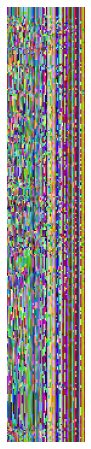

In [3]:
from numpy.linalg import eig

height, width, dim = image.shape

R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

def pca(X, k):
    X_mean = np.mean(X, axis=0)
    X_new = X - X_mean
    
    X_covariance = np.cov(X_new.T)
    eigenvalues, eigenvectors = eig(X_covariance)
    
    order_eigens = [
      (np.abs(eigenvalues[i]),
       eigenvectors[:, i]
      ) for i in range(len(eigenvalues))
    ]
    order_eigens.sort()
    order_eigens.reverse()
    
    order_eigenvalues = [eigen[1] for eigen in order_eigens]

    return np.dot(X, np.array(order_eigenvalues[:k]).T)

R_pca = pca(R, 64)
G_pca = pca(G, 64)
B_pca = pca(B, 64)

image_pca = np.dstack([R_pca, G_pca, B_pca])

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(image_pca.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

### Bilinear resize
As we could't make the pca work properly to resize, because it will modify our matrix of rgb and will lose some information.

So we decided to implement some interpolation methods to make our riseze and apply some filters to the image to make it look better.

The bilinear interpolation work by calculating the linear interpolation from one direction, x, and then on the other direction, y. So different from the 1D array used in linear interpolation, we will use an 2D array for bilinear.

The main problem it's that we have an RGB image, so a 3D array. To use the bilinear we have to split the R, G and B components.

In [4]:
def resize_image(image, function, k=32):
    height, width, dim = image.shape
    propotion = k/width
    
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    R_re = bilinear_resize(R, int(height*propotion), k)
    G_re = bilinear_resize(G, int(height*propotion), k)
    B_re = bilinear_resize(B, int(height*propotion), k)
    
    return np.dstack([R_re, G_re, B_re])

def bilinear_resize(image, height, width):
    img_height, img_width = image.shape
    image_resized = np.zeros([height, width])

    row_ratio = float(img_width - 1) / (width - 1)
    col_ratio = float(img_height - 1) / (height - 1)

    for i in range(height):
        for j in range(width):

            x_w = int(np.floor(row_ratio * j))
            y_w = int(np.floor(col_ratio * i))
            x_h = int(np.round(row_ratio * j))
            y_h = int(np.round(col_ratio * i))

            row_weight = (row_ratio * j) - x_w
            col_weight = (col_ratio * i) - y_w

            a = image[y_w, x_w]
            b = image[y_w, x_h]
            c = image[y_h, x_w]
            d = image[y_h, x_h]

            pixel = a * (1 - row_weight) * (1 - col_weight) \
                  + b * row_weight * (1 - col_weight) + \
                  c * col_weight * (1 - row_weight) + \
                  d * row_weight * col_weight

            image_resized[i][j] = pixel
    return image_resized

Now that we have our funcition we will try to resize the image to 32 pixels, maintaning the proportion

(46, 32, 3)
(361, 250, 3)


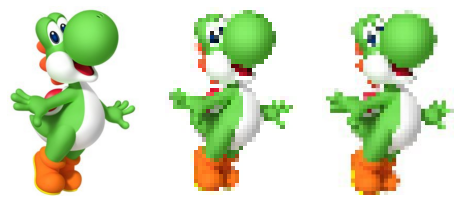

In [5]:
image_resized = resize_image(image, bilinear_resize)

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(output_intended.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

print(image_resized.shape)
print(image.shape)

If we compare our 3 images: original, our, expected; we can see that in some aliasing pixels, especially at the outline of our character. 

So we're going to apply some filter trying to preserve the quality.

Firstly, we convert our image from jpeg to png, this way we can clear some blur from the outline improving the image quality. We used aseprite to convert the image.

(-0.5, 31.5, 45.5, -0.5)

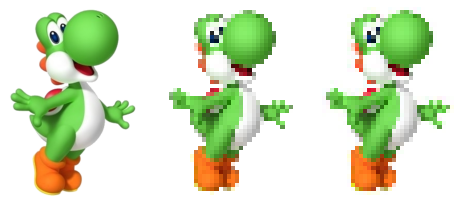

In [6]:
image_new = imageio.imread('README/example1.png')

image_new_resized = resize_image(image_new, bilinear_resize)

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_new.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_new_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

But using png we didn't improve that much our image. But we could at least improve a bit some outline pixels as we wanted.

So we create another function that will do the nearest neighbor interpolation. This function will get the pixels with least distance, not calculating anything with them.

In [7]:
def nearest_neighbor_resize(image, height, width):
    img_height, img_width = image.shape
    
    row_ratio = width / img_width
    col_ratio = height / img_height
    
    row_generator = range(1, 1 + int(img_width*row_ratio))
    col_generator = range(1, 1 + int(img_height*col_ratio))
    
    row_list = np.array(row_generator)/row_ratio
    col_list = np.array(col_generator)/col_ratio
    
    row_index = (np.round(row_list) - 1).astype(np.int)
    col_index = (np.round(col_list) - 1).astype(np.int)
    
    return image[:, row_index][col_index, :]

(-0.5, 31.5, 45.5, -0.5)

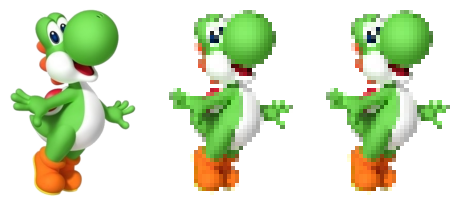

In [8]:
image_nn = resize_image(image_new, nearest_neighbor_resize)

imageio.imwrite('image_nn.png', image_nn.astype(np.uint8))

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_new.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_nn.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_new_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

Now we have a better effect with the outline pixels and we didn't lose any important color like the shoes sole.
For the next step, we want to try other kinds of image scaling to check if we can achieve a better result than our own Nearest Neighbor

### Skimage - Block_Reduce

It is a function that is capable of downsampling images to a more coarse resolution. Althought it is more used with data manupulation, we can test how different median and mean function affect pixel art.

(-0.5, 31.5, 45.5, -0.5)

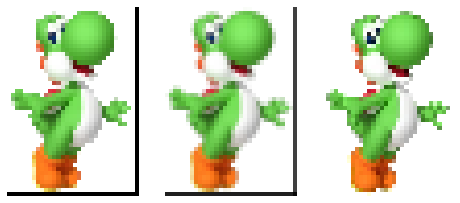

In [9]:
from skimage.measure import block_reduce
k = 8

R_median = block_reduce(image_new[:, :, 0],(k,k), func=np.median)
G_median = block_reduce(image_new[:, :, 1],(k,k), func=np.median)
B_median = block_reduce(image_new[:, :, 2],(k,k), func=np.median)

image_median = np.dstack([R_median, G_median, B_median])

R_mean = block_reduce(image_new[:, :, 0],(k,k), func=np.mean)
G_mean = block_reduce(image_new[:, :, 1],(k,k), func=np.mean)
B_mean = block_reduce(image_new[:, :, 2],(k,k), func=np.mean)

image_mean = np.dstack([R_mean, G_mean, B_mean])

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_median.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_mean.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_nn.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

The first image, using median function, has a really nice result, with just a few blur pixels and mantaining the yellow from his sole, unfortanly for some reason, using median or mean fuction produces this strange black lines in the image boarders

### Skimage - Resize and Downscale_local_mean

Resize: Performs interpolation to up-size or down-size N-dimensional images. It has an anti_aliasing feature

Downscale_local_mean: Down-sample N-dimensional image by local averaging.

(-0.5, 31.5, 45.5, -0.5)

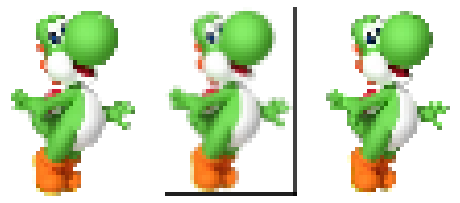

In [10]:
from skimage.transform import resize, downscale_local_mean

R_resized = resize(image_new[:, :, 0], (int(height * 32/width), 32),
                       anti_aliasing=False)
G_resized = resize(image_new[:, :, 1], (int(height * 32/width), 32),
                       anti_aliasing=False)
B_resized = resize(image_new[:, :, 2], (int(height * 32/width), 32),
                       anti_aliasing=False)

image_resized = np.dstack([R_resized, G_resized, B_resized])


R_downscaled = downscale_local_mean(image_new[:, :, 0], (8, 8))
G_downscaled = downscale_local_mean(image_new[:, :, 1], (8, 8))
B_downscaled = downscale_local_mean(image_new[:, :, 2], (8, 8))

image_downscaled = np.dstack([R_downscaled, G_downscaled, B_downscaled])

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_resized, vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_downscaled.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_nn.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

The resized has few blurred pixels, but has inconsistency in hands and eyes.
The downscaled uses mean function so it is very similarly to the mean function from block reduce.

### Pillow - Box and Bicubic

Box filter uses each pixel of source image as one pixel of the destination image with identical weights.

Bicubic filter is more frequently used for upscaling images by calculating the destination image with euclidean distance.

(-0.5, 31.5, 45.5, -0.5)

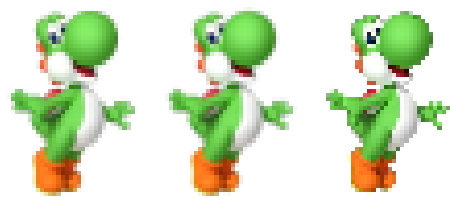

In [11]:
from PIL import Image

image_reduced = Image.open("README/example1.png").convert("RGB")
image_box = image_reduced.resize((32, (int(height * 32/width))), Image.BOX)
image_bicubic = image_reduced.resize((32, (int(height * 32/width))), Image.BICUBIC)

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_box, vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_bicubic, vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_new_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

In this case blur is a real problem, one weakness of bicubic, box and related algorithms is that they sample a specific number of pixels, therefor they need a box sampling to fix it but this algorithm is hard to optimize 

But we still have too many colors to be a perfect pixel art. Now we're going to use our new image with nearest neighbor resize and apply some filter to improve the colors. Our first ideia is to convert our image to HSV and divide it by hue regionsand then HUE shifting depending on the saturation and value to achieve this:

(-0.5, 31.5, 45.5, -0.5)

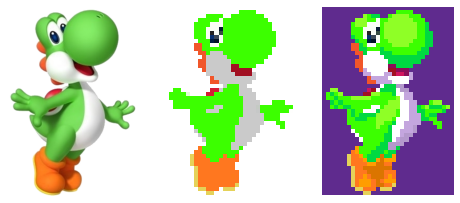

In [30]:
image_color_out = imageio.imread('README/image_example_colorout.png')
image_hue = imageio.imread('README/image_example_hueshift.png')

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_new.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_color_out.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_hue.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

### HSV

The hue of the image is not as we thought, white/black pixels can have any level of hue, in this way we cannot separate by hue regions

<BarContainer object of 255 artists>

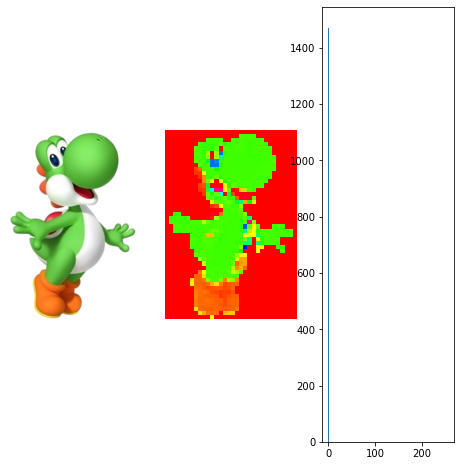

In [31]:
import matplotlib as mpl

imageNew_hsv = mpl.colors.rgb_to_hsv(image_nn)

plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(image_new.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(imageNew_hsv[:, :, 0], cmap="hsv")
plt.axis('off')

plt.subplot(133)
hist, _ = np.histogram(imageNew_hsv[:, :, 0], bins=255, range=(0,255))
plt.bar(np.arange(0,255), hist)

In [32]:
def pixelartIt(imageNew_hsv):
    # Saturation
    imageNew_hsv[:, :, 1] = np.where(imageNew_hsv[:, :, 1] < 0.2, 0, imageNew_hsv[:, :, 1])
    imageNew_hsv[:, :, 0] = np.where(imageNew_hsv[:, :, 1] == 0, 0.8, imageNew_hsv[:, :, 0])

    # Value
    imageNew_hsv[:, :, 2] = np.where(imageNew_hsv[:, :, 2] <= 85, 85, imageNew_hsv[:, :, 2])
    imageNew_hsv[:, :, 2] = np.where(np.logical_and(imageNew_hsv[:, :, 2] > 85, imageNew_hsv[:, :, 2] <= 170), 170, imageNew_hsv[:, :, 2])
    imageNew_hsv[:, :, 2] = np.where(np.logical_and(imageNew_hsv[:, :, 2] > 170, imageNew_hsv[:, :, 2] <= 210), 210, imageNew_hsv[:, :, 2])
    imageNew_hsv[:, :, 2] = np.where(np.logical_and(imageNew_hsv[:, :, 2] > 210, imageNew_hsv[:, :, 2] <= 240), 240, imageNew_hsv[:, :, 2])
    imageNew_hsv[:, :, 2] = np.where(imageNew_hsv[:, :, 2] > 240, 255, imageNew_hsv[:, :, 2])

    imageNew_hsv[:, :, 1] = np.where(np.logical_and(imageNew_hsv[:, :, 2] <= 240, imageNew_hsv[:, :, 1] == 0), 0.2, imageNew_hsv[:, :, 1])

    # Hue
    #imageNew_hsv[:,:,0] = np.where(imageNew_hsv[:, :, 2] == 240, imageNew_hsv[:,:,0]-0.05, imageNew_hsv[:,:,0])
    #imageNew_hsv[:,:,0] = np.where(imageNew_hsv[:, :, 2] == 170, imageNew_hsv[:,:,0]+0.15, imageNew_hsv[:,:,0])
    #imageNew_hsv[:,:,0] = np.where(imageNew_hsv[:, :, 2] == 85, imageNew_hsv[:,:,0]+0.3, imageNew_hsv[:,:,0])

    return mpl.colors.hsv_to_rgb(imageNew_hsv)
    

(-0.5, 31.5, 45.5, -0.5)

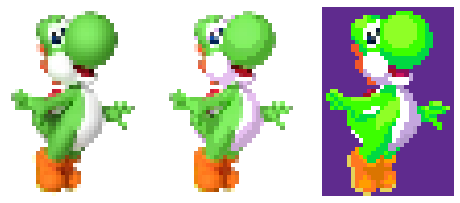

In [33]:
image_tst = pixelartIt(imageNew_hsv)

plt.figure(figsize=(8, 8))

plt.subplot(131)
plt.imshow(image_new_resized.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(image_tst.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(image_hue.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

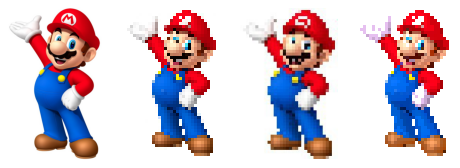

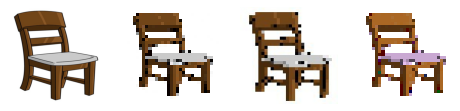

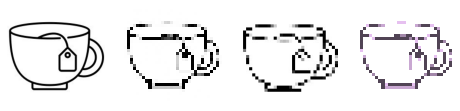

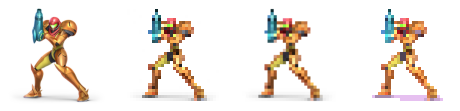

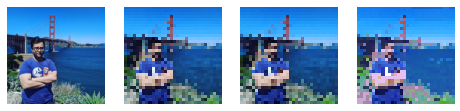

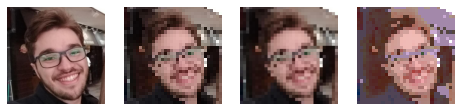

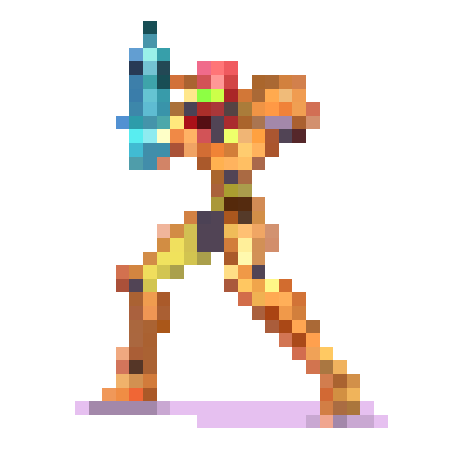

In [34]:
image2 = imageio.imread('README/example2.jpg')
output_intended2 = imageio.imread('README/example2.out.jpg')
image_nn2 = resize_image(image2, bilinear_resize)
image_pixelart2 = pixelartIt(mpl.colors.rgb_to_hsv(image_nn2))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(image2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nn2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intended2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelart2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

image3 = imageio.imread('README/example3.jpg')
output_intended3 = imageio.imread('README/example3.out.jpg')
image_nn3 = resize_image(image3, nearest_neighbor_resize)
image_pixelart3 = pixelartIt(mpl.colors.rgb_to_hsv(image_nn3))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(image3.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nn3.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intended3.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelart3.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

image4 = imageio.imread('README/example4.jpg')
output_intended4 = imageio.imread('README/example4.out.jpg')
image_nn4 = resize_image(image4, nearest_neighbor_resize)
image_pixelart4 = pixelartIt(mpl.colors.rgb_to_hsv(image_nn4))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(image4.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nn4.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intended4.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelart4.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

image5 = imageio.imread('README/example5.png')
output_intended5 = imageio.imread('README/example5out.png')
image_nn5 = resize_image(image5, nearest_neighbor_resize)
image_pixelart5 = pixelartIt(mpl.colors.rgb_to_hsv(image_nn5))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(image5.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nn5.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intended5.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelart5.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

imageBonus = imageio.imread('README/examplebonus.jpg')
output_intendedBonus = imageio.imread('README/examplebonusout.png')
image_nnBonus = resize_image(imageBonus, nearest_neighbor_resize)
image_pixelartBonus = pixelartIt(mpl.colors.rgb_to_hsv(image_nnBonus))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(imageBonus.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nnBonus.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intendedBonus.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelartBonus.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

imageBonus2 = imageio.imread('README/examplebonus2.jpg')
output_intendedBonus2 = imageio.imread('README/examplebonus2out.png')
image_nnBonus2 = resize_image(imageBonus2, nearest_neighbor_resize)
image_pixelartBonus2 = pixelartIt(mpl.colors.rgb_to_hsv(image_nnBonus2))

plt.figure(figsize=(8, 8))
plt.subplot(141)
plt.imshow(imageBonus2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(142)
plt.imshow(image_nnBonus2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(143)
plt.imshow(output_intendedBonus2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(144)
plt.imshow(image_pixelartBonus2.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(image_pixelart5.astype(np.uint8), vmin=0, vmax=255)
plt.axis('off')


## Result

Comparing our 4 results with the image we generate with aseprite, we can notice that our method, neighborhood and bilinear go better in some cases to identify the better outline. But one problem is that when we have an image with too much light and shadow our method cannot ignore it and only give some blur. But we can mantain the properties of the image.

Althought that was not the exactly goal that we want, we try to get only some color of the image and generate a new image, to have a better use at pixel art games. To do that we try to convert our image to HSV and identify the colors there but the histogram was not good enough and we don't know how to define a limit of colors. If the user define a color limit, like 4 colors, we can develop a better method.

So our next goal it's to divide our image in regions of colors and then define a new color to all that pixels.